# Intersection Graph Construction
To properly simulate bicyclist behavior, we need a graph that represents how a bicyclist can travel around a city. Idealy we will create a graph that models the interactions between road segemnts and intersections.

Intersections:
* A "fully connected" intersection must allow byclicts to leave any direction that they are physically and legally allowed to.
 * Can not enter a one way street if going the wrong direction
 * Can't do a left turn if there exists a no left turn sign

Segments:
* After transforming intersections into new nodes, segments should preserve the original connectivity between those original nodes with newly created edges for the new nodes.

# Strategy

### Connectivity 1 -> Geometry -> Connectivity 2 -> Data -> Data 2

Connectivity 1:
* Use the in_out_dict of all the nodes and their edges to create a new set of nodes that represents the original segments and newly defined intersections. This step creates all the nodes that will ever be needed, but the edges will be updated with bicyclist behavior and traffic signaling.

Geometry:
* Use the geometry of the original nodes to determine good locations for the newly created nodes.

Connectivity 2:
* Use the geometry to determine left turns and fill in the missing bicyclist two part left turn

Data:
* Use data to remove any traffic defined impediments (such as a not left turn sign)

Data 2:
* Integrate external data sources into graph

## Imports & setup

In [1]:
import osmnx as ox

In [94]:
import numpy as np

In [5]:
from collections import defaultdict

We use a sample bounding box centered below Washington DC. This particular section of Arlington is not particularly interesting but it should let us experiment with initial graph construction.

In [2]:
bbox_east, bbox_north, bbox_south, bbox_west = -77.032086, 38.934280, 38.827447, -77.172320

n = 120

ew_dist = bbox_east - bbox_west
ew_avg = (bbox_east + bbox_west)/2
bbox_east = ew_avg + ew_dist/n
bbox_west = ew_avg - ew_dist/n

ns_dist = bbox_north - bbox_south
ns_avg = (bbox_north + bbox_south)/2
bbox_north = ns_avg + ns_dist/n
bbox_south = ns_avg - ns_dist/n

In [3]:
bbox_graph = ox.graph_from_bbox(bbox_north, bbox_south, bbox_east, bbox_west)

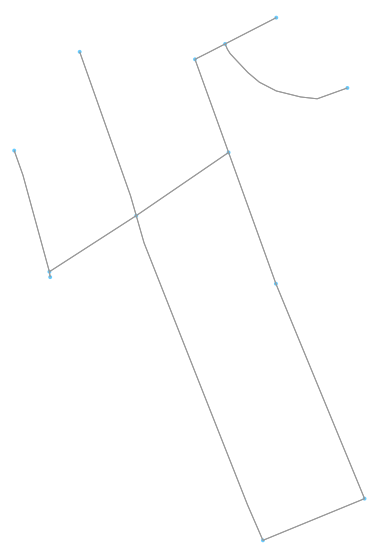

(<Figure size 619.923x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa793d1b7f0>)

In [4]:
ox.plot_graph(bbox_graph, fig_height=10)

## In_out dictionary

The in_out dictionary is an intermediate representation of our graph for to allow easier computing of the desired graph. For every node, we simply list what nodes travel **in** to that node, and what nodes you can get to by traveling **out** of that node

In [6]:
def make_dict():
    return {'in':[],'out':[]}

In [7]:
in_out = defaultdict(make_dict)
for start, end in bbox_graph.edges():
    in_out[end]['in'].append(start)
    in_out[start]['out'].append(end)
in_out

defaultdict(<function __main__.make_dict()>,
            {63334966: {'in': [5441299616, 5441299617, 5441299823],
              'out': [5441299616, 5441299823, 5441299617]},
             5441299616: {'in': [63334966], 'out': [63334966]},
             5441299617: {'in': [63334966], 'out': [63334966]},
             5600335194: {'in': [5441299822, 5662408421],
              'out': [5441299822, 5662408421]},
             5441299822: {'in': [5441299823, 63334543, 5600335194],
              'out': [5600335194, 63334543, 5441299823]},
             63334543: {'in': [5441299822, 63327691],
              'out': [5441299822, 63327691]},
             5441299823: {'in': [5441299822, 5441299824, 5441299828, 63334966],
              'out': [5441299822, 63334966, 5441299824, 5441299828]},
             5441299824: {'in': [5441299823], 'out': [5441299823]},
             5441299828: {'in': [5441299823, 63327691],
              'out': [63327691, 5441299823]},
             63327691: {'in': [5441299828, 6333

## Connectivity 1

Construct the initial graph from the given OSMnx data.

In [8]:
nodes = set()

### Segments

In [9]:
segments = set()
for k, v in in_out.items():
    for node in v['in']:
        n1 = (node, k, 'out')
        n2 = (k, node, 'in')
        nodes.add(n1)
        nodes.add(n2)
        segments.add((n1, n2))
len(segments)

26

### Intersections

In [10]:
intersections = set()
for k, v in in_out.items():
    # every in connects to every out - unless same node
    for n_in in v['in']:
        n1 = (k, n_in, 'in')
        for n_out in v['out']:
            n2 = (k, n_out, 'out')
            
            nodes.add(n1)
            nodes.add(n2)
            
            if n_in != n_out:
                intersections.add((n1, n2))
len(intersections)

38

In [11]:
edges = set.union(segments, intersections)
len(edges)

64

## Geometry

1st pass: Give each node in the graph a somewhat decent (x,y) position.

2nd pass: Construct proper shapely curves for the edges.

In [12]:
bbox_graph.nodes()[2219272722]

{'y': 38.8816352, 'x': -77.102142, 'osmid': 2219272722}

make a lookup of the (x,y) for each node mostly for ease of use

In [13]:
nodes_xy = {}
for node in nodes:
    xy = bbox_graph.nodes()[node[0]]
    x = xy['x']
    y = xy['y']
    nodes_xy[node] = {'x': x, 'y': y}

In [73]:
def complement_dir(s: str):
    """
    TODO: Switch to True and False so I don't have to write this function
    """
    if s == 'in':
        return 'out'
    elif s == 'out':
        return 'in'
    else:
        print("complement_dir failed")

In [90]:
def complement_segment(segment):
    """
    Computes the complementary segment of the given segment. The
    complementary segement represents the other direction in a two
    way street.
    """
    n0 = segment[0]
    n1 = segment[1]

    n3 = (n0[0], n0[1], complement_dir(n0[2]))
    n2 = (n1[0], n1[1], complement_dir(n1[2]))
    
    return (n2, n3)

In [101]:
def xy_vec(n1, n2):
    """
    Calculates the vector that takes you from n1 to n2
    """
    xy1 = nodes_xy[n1]
    xy2 = nodes_xy[n2]
    
    dx = xy2['x'] - xy1['x']
    dy = xy2['y'] - xy1['y']
    
    return np.array((dx, dy))

def segment_vec(segment):
    return xy_vec(segment[0], segment[1])

def segment_unit_vec(segment):
    arr = segment_vec(segment)
    return arr / np.linalg.norm(arr)    

In [110]:
vec = segment_vec(segment)
length = np.linalg.norm(vec)
unit_vec = segment_unit_vec(segment)
length, vec, unit_vec

(0.00030956553426011475,
 array([-0.0001301,  0.0002809]),
 array([-0.42026642,  0.90740076]))

In [119]:
vec - (.0001 * unit_vec)

array([-8.80733576e-05,  1.90159924e-04])

In [106]:
for segment in segments:
    segment_comp = complement_segment(segment)
    if segment_comp in segments:
        print("two way street!")
        print(segment_unit_vec(segment))
        
        
        print(segment_unit_vec(segment_comp))
    else:
        print("one way street!")
        print(segment_unit_vec(segment))

two way street!
[0.88253045 0.47025525]
[-0.88253045 -0.47025525]
two way street!
[-0.42014804  0.90745558]
[ 0.42014804 -0.90745558]
two way street!
[-0.92850898 -0.37130994]
[0.92850898 0.37130994]
two way street!
[0.92850898 0.37130994]
[-0.92850898 -0.37130994]
two way street!
[-0.40552043  0.91408598]
[ 0.40552043 -0.91408598]
two way street!
[ 0.40552043 -0.91408598]
[-0.40552043  0.91408598]
two way street!
[-0.89352255 -0.44901832]
[0.89352255 0.44901832]
two way street!
[ 0.42014804 -0.90745558]
[-0.42014804  0.90745558]
two way street!
[-0.88253045 -0.47025525]
[0.88253045 0.47025525]
two way street!
[-0.3494931   0.93693894]
[ 0.3494931  -0.93693894]
two way street!
[0.95255329 0.30437187]
[-0.95255329 -0.30437187]
two way street!
[-0.46819464  0.88362536]
[ 0.46819464 -0.88362536]
two way street!
[-0.92940827 -0.3690532 ]
[0.92940827 0.3690532 ]
two way street!
[ 0.46819464 -0.88362536]
[-0.46819464  0.88362536]
two way street!
[-0.96293023  0.26975056]
[ 0.96293023 -0.2697

In [62]:
segment = list(segments)[0]

In [63]:
segment_comp = complement_segment(segment)

In [64]:
segment

((5441299823, 5441299822, 'out'), (5441299822, 5441299823, 'in'))

In [65]:
segment_comp

((5441299822, 5441299823, 'out'), (5441299823, 5441299822, 'in'))

In [37]:
dir01 = xy_vec(segment[0], segment[1])

In [18]:
bbox_graph.nodes()[segment[0][0]], bbox_graph.nodes()[segment[1][0]]

({'y': 38.8810381, 'x': -77.1026845, 'osmid': 5441299823},
 {'y': 38.8812287, 'x': -77.1023268, 'osmid': 5441299822})

## Connectivity 2

Use the geometry to determine left turns and fill in the missing bicyclist two part left turn

## Data

Use data to remove any traffic defined impediments (such as a not left turn sign)

## Data 2

Add data into the graph

In [19]:
bbox_graph.nodes(data=True)

NodeDataView({5441299616: {'y': 38.8808526, 'x': -77.1030179, 'osmid': 5441299616}, 5441299617: {'y': 38.8812344, 'x': -77.1031573, 'osmid': 5441299617}, 5441299822: {'y': 38.8812287, 'x': -77.1023268, 'osmid': 5441299822}, 5441299823: {'y': 38.8810381, 'x': -77.1026845, 'osmid': 5441299823}, 5441299824: {'y': 38.8815322, 'x': -77.1029037, 'osmid': 5441299824}, 5441299828: {'y': 38.8800589, 'x': -77.1021938, 'osmid': 5441299828}, 63334543: {'y': 38.8808328, 'x': -77.1021435, 'osmid': 63334543}, 2219272722: {'y': 38.8816352, 'x': -77.102142, 'osmid': 2219272722}, 63334966: {'y': 38.880869, 'x': -77.103021, 'osmid': 63334966}, 5600335178: {'y': 38.8814232, 'x': -77.1018666, 'osmid': 5600335178}, 5600335194: {'y': 38.8815096, 'x': -77.1024569, 'osmid': 5600335194}, 63327691: {'y': 38.8801847, 'x': -77.1018001, 'osmid': 63327691}, 5662408421: {'y': 38.8815559, 'x': -77.1023403, 'osmid': 5662408421}})

### Create Graph

In [20]:
import networkx as nx

In [30]:
G = nx.MultiDiGraph()
G.graph = {'name': 'Test Graph','crs': {'init': 'epsg:4326'},'simplified': True}
G.add_nodes_from([(k, v) for k, v in nodes_xy.items()])

In [31]:
edges = set.union(segments, intersections)
edges = [(u,v,0,{}) for u,v in edges]
G.add_edges_from(edges);

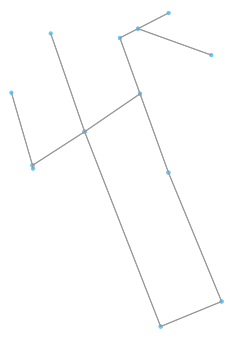

In [36]:
ox.plot_graph(G);

In [ ]:
def create_test_graph():
    G = nx.DiGraph()


    edge12 = (1,2,{"from":1, "to":2, "length": 3, "signalized":0, "separated":0, "traffic":1}) # only consistent good feature is traffic
    edge23 = (2,3,{"from":2, "to":3, "length": 4, "signalized":1, "separated":0, "traffic":1})
    edge34 = (3,4,{"from":3, "to":4, "length": 3, "signalized":0, "separated":1, "traffic":1})

    edge16 = (1,6,{"from":1, "to":6, "length": 3, "signalized":1, "separated":0, "traffic":2}) # only consistent good feature is signalization
    edge67 = (6,7,{"from":6, "to":7, "length": 4, "signalized":1, "separated":1, "traffic":4})
    edge74 = (7,4,{"from":7, "to":4, "length": 3, "signalized":1, "separated":0, "traffic":3})

    edge18 = (1,8,{"from":1, "to":8, "length": 3, "signalized":0, "separated":1, "traffic":1}) # only consistent good feature is separation
    edge89 = (8,9,{"from":8, "to":9, "length": 4, "signalized":1, "separated":1, "traffic":1})
    edge94 = (9,4,{"from":9, "to":4, "length": 3, "signalized":0, "separated":1, "traffic":1})

    edge15 = (1,5,{"from":1, "to":5, "length": 3, "signalized":0, "separated":0, "traffic":4}) # everything is bad here
    edge54 = (5,4,{"from":5, "to":4, "length": 3, "signalized":0, "separated":0, "traffic":4}) 


    
    nodeList = [(1, {'displacement':10}),
                (2, {'displacement':6}),
                (3, {'displacement':3}),
                (4, {'displacement':0}),
                (5, {'displacement':7}),
                (6, {'displacement':6}),
                (7, {'displacement':3}),
                (8, {'displacement':6}),
                (9, {'displacement':3})]
    edgeList = [edge12,edge23,edge34,edge15,edge54,edge16,edge67,edge74,edge18,edge89,edge94]
    

    G.add_nodes_from(nodeList)
    G.add_edges_from(edgeList)
        
    return G

In [ ]:
test_G = create_test_graph()

In [ ]:
test_G.nodes(data=True)